In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 9s 0us/step


In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [7]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/geist/Desktop/projects/kaggle/cats_dogs/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels= np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [9]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

In [10]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr=2e-5),
             loss = 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, 
                    validation_data=(validation_features,validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.6178 - acc: 0.6500 - val_loss: 0.4463 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 0s 213us/step - loss: 0.4361 - acc: 0.7990 - val_loss: 0.3600 - val_acc: 0.8560
Epoch 3/30
2000/2000 [==============================] - 0s 216us/step - loss: 0.3521 - acc: 0.8525 - val_loss: 0.3230 - val_acc: 0.8760
Epoch 4/30
2000/2000 [==============================] - 0s 214us/step - loss: 0.3229 - acc: 0.8590 - val_loss: 0.3142 - val_acc: 0.8680
Epoch 5/30
2000/2000 [==============================] - 0s 213us/step - loss: 0.2886 - acc: 0.8830 - val_loss: 0.2821 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 0s 213us/step - loss: 0.2749 - acc: 0.8850 - val_loss: 0.2705 - val_acc: 0.8940
Epoch 7/30
2000/2000 [==============================] - 0s 214us/step - loss: 0.2479 - acc: 0.9015 - val_loss: 0.2632 - val_acc: 0.8970
Ep

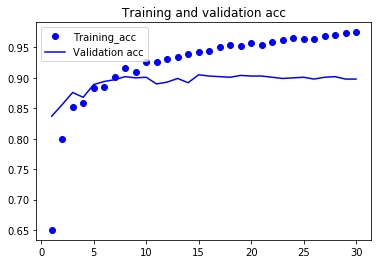

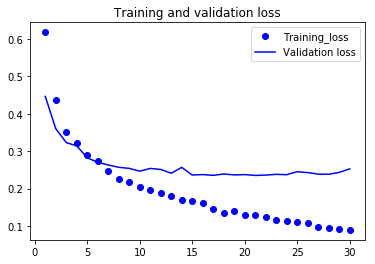

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training_acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training_loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Accuracy of ~90%